In [1]:
import nltk
from nltk.corpus import treebank

# get sentences parsed as trees
tree_sents = treebank.parsed_sents()

# split sentences into training and testing datasets
train_ratio = 0.9
train_size = int(len(tree_sents) * train_ratio)
tree_sents_train, tree_sents_test = tree_sents[:train_size], tree_sents[train_size:]

In [2]:
# functions for filtering NP subtrees which are non-recursive
# check if exist a child that has the specific label
def child_has_label(t, label):
    for child in t:
        if label == child.label():
            return True
    return False

# check if tree is NP and no direct child is NP (non recursive NP)
nonrec_np = lambda t : t.label() == 'NP' and not child_has_label(t, 'NP')
# filter non-recursive NP trees
get_nonrec_np_subtrees = lambda tree_sents : [[sub_t for sub_t in t.subtrees(nonrec_np)] for t in tree_sents]

# non-recursive NP trees grouped by sentences
nonrec_np_subts_train = get_nonrec_np_subtrees(tree_sents_train)
nonrec_np_subts_test = get_nonrec_np_subtrees(tree_sents_test)

In [3]:
# Example
tree_sents_train[0].pretty_print() # text
#tree_sents_train[0].draw() # graphical UI

                                                     S                                                                         
                         ____________________________|_______________________________________________________________________   
                        |                                               VP                                                   | 
                        |                        _______________________|___                                                 |  
                      NP-SBJ                    |                           VP                                               | 
         _______________|___________________    |     ______________________|______________________________________          |  
        |          |              ADJP      |   |    |        |                PP-CLR                              |         | 
        |          |           ____|____    |   |    |        |          ________|_________          

In [4]:
# NP chunks grouped by sentences
chunks_train = [[sub_t.leaves() for sub_t in t] for t in nonrec_np_subts_train]
chunks_test = [[sub_t.leaves() for sub_t in t] for t in nonrec_np_subts_test]

In [5]:
# Example
# NP chunks
chunks_train[0]

[[u'Pierre', u'Vinken'],
 [u'61', u'years'],
 [u'the', u'board'],
 [u'a', u'nonexecutive', u'director']]

In [6]:
# Example
# graphical view of the NP chunks as trees
for sub_t in nonrec_np_subts_train[0]:
    sub_t.pretty_print() # text
    #sub_t.draw() # graphical UI

        NP       
   _____|____     
 NNP        NNP  
  |          |    
Pierre     Vinken

     NP      
  ___|____    
 CD      NNS 
 |        |   
 61     years

     NP      
  ___|____    
 DT       NN 
 |        |   
the     board

         NP              
  _______|__________      
 DT      JJ         NN   
 |       |          |     
 a  nonexecutive director



In [7]:
# get the grammar rules, also called productions
get_productions = lambda tree_sents : [p for sent in tree_sents for p in sent.productions()]

import itertools
prods_train = get_productions(itertools.chain(*nonrec_np_subts_train))
prods_test  = get_productions(itertools.chain(*nonrec_np_subts_test))

# filter non-terminal productions
is_non_terminal = lambda p : p.is_nonlexical()
prods_train = filter(is_non_terminal, prods_train)
prods_test = filter(is_non_terminal, prods_test)

In [8]:
# Example
prods = filter(is_non_terminal, get_productions(nonrec_np_subts_train[0]))
prods

[NP -> NNP NNP, NP -> CD NNS, NP -> DT NN, NP -> DT JJ NN]

In [9]:
# compute productions frequency
from nltk.probability import FreqDist
fdist = FreqDist(prods_train)

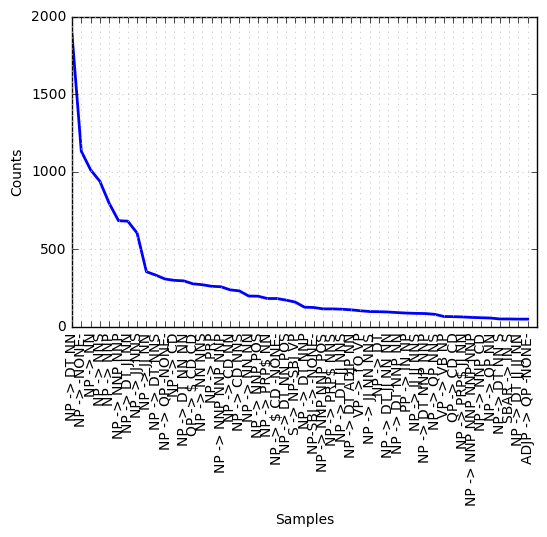

In [10]:
# Example
# Plot the 50 most frequent rules
fdist.plot(50)

In [11]:
# Example
# Get the 10 most frequent rules
fdist.most_common(10)

[(NP -> DT NN, 1888),
 (NP -> -NONE-, 1133),
 (NP -> NN, 1013),
 (NP -> NNS, 939),
 (NP -> NNP, 797),
 (NP -> NNP NNP, 685),
 (NP -> DT JJ NN, 682),
 (NP -> JJ NNS, 605),
 (NP -> JJ NN, 356),
 (NP -> DT NNS, 334)]

In [12]:
# compute coverage ?
unique_prods_train = set(prods_train)
unique_prods_test  = set(prods_test)

# number of unique productions in testing set covered by training set
coverage = 1. * len(unique_prods_train & unique_prods_test) / len(unique_prods_test)

In [13]:
coverage

0.6942148760330579

In [14]:
# compute accuracy ?
prods_test_contained_in_train = 0
for p in prods_test:
    if p in unique_prods_train:
        prods_test_contained_in_train += 1

# number of productions (including repetitions) in testing set covered by training set
accuracy = 1.0 * prods_test_contained_in_train / len(prods_test)

In [15]:
accuracy

0.9422222222222222

In [16]:
#from nltk.grammar import PCFG, induce_pcfg, Nonterminal
#treebank_prob_grammar = induce_pcfg(Nonterminal('S'), prods_train)

In [17]:
#treebank_prob_grammar.productions()